# Unskewing COVID-19 Case Count
Kartik Chugh - May 3, 2020

Over the past few months, the coronavirus pandemic has devastated communities on a global scale, with roughly 3.5 million cases worldwide and over a million in the United States alone, at the time of this writing.

 <img src="china-data.png" />

In [46]:
import numpy as np
import pandas as pd
from pandas import Timestamp, Series
import matplotlib as mpl
from matplotlib import pyplot as plt
from datetime import datetime, timedelta

np.set_printoptions(suppress=True,
   formatter={'float_kind':'{:0.3f}'.format})

%config InlineBackend.figure_format = 'retina'

In [47]:
ONSET_TO_DEATH = 17 # https://midasnetwork.us/covid-19/
MORTALITY_RATE = 0.01

In [75]:
url = 'https://covidtracking.com/api/v1/us/daily.csv' # https://covidtracking.com/api
df = pd.read_csv(url, 
            usecols=['date', 'positiveIncrease', 'deathIncrease', 'positive'], 
            parse_dates=['date'], 
            index_col=['date']).sort_index().iloc[1:]

time = df.index

In [76]:
pd.set_option('display.max_rows', None)
df

,positive,deathIncrease,positiveIncrease
date,,,
2020-01-23,1,0.0,0.0
2020-01-24,1,0.0,0.0
2020-01-25,1,0.0,0.0
2020-01-26,1,0.0,0.0
2020-01-27,1,0.0,0.0
2020-01-28,1,0.0,0.0
2020-01-29,1,0.0,0.0
2020-01-30,1,0.0,0.0
2020-01-31,1,0.0,0.0


In [50]:
def doublingTime(a, b):
    return np.log(2)/np.log(b/a) if (a != b) else np.nan

lower = 2.4
doubling = np.zeros(df['positive'].shape)
for t in range(1, len(doubling)):
    doubling[t] = doublingTime(df['positive'][t-1], df['positive'][t])
    
doubling_orig = pd.DataFrame(doubling, columns=['doubling time'], index=time)
    
doubling_smooth = doubling_orig.rolling(7,
        win_type='gaussian',
        min_periods=1,
        center=True).mean(std=3).round().clip(lower=lower).fillna(lower)

In [51]:
doubling_smooth

,doubling time
date,
2020-01-23,2.4
2020-01-24,2.4
2020-01-25,2.4
2020-01-26,2.4
2020-01-27,2.4
2020-01-28,2.4
2020-01-29,2.4
2020-01-30,2.4
2020-01-31,2.4


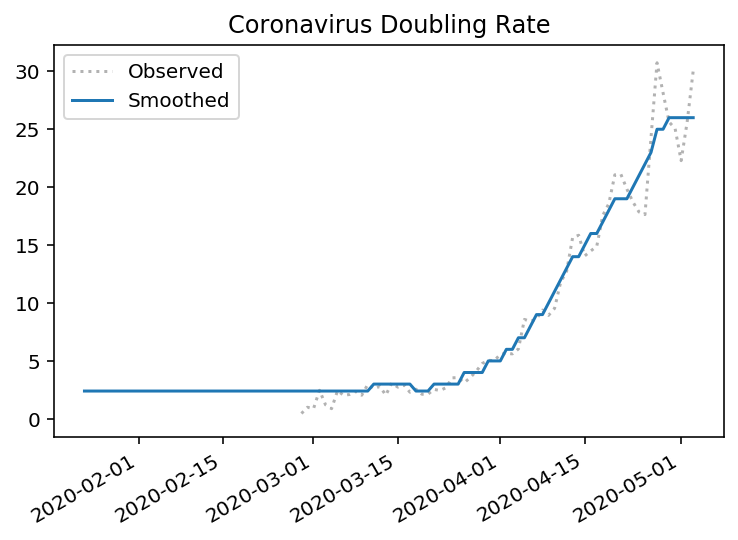

In [52]:
plt.plot(doubling_orig, c='k', ls=':', alpha=.3)
plt.plot(doubling_smooth)
plt.gcf().autofmt_xdate()
plt.legend(['Observed', 'Smoothed'])
plt.title('Coronavirus Doubling Rate')
plt.show()

In [53]:
t_init = df['deathIncrease'].ne(0).idxmax()
t_init

Timestamp('2020-02-26 00:00:00')

In [54]:
d_init = df['deathIncrease'][t_init]
d_init

2.0

In [55]:
t0 = t_init - timedelta(days=ONSET_TO_DEATH)
t0

Timestamp('2020-02-09 00:00:00')

In [56]:
C0 = d_init * 1/MORTALITY_RATE
C0

200.0

In [70]:
C = np.full(df['positive'].shape, C0)

In [71]:
cf = 0.75

for t in range((t0-time[0]).days, -1, -1):
    db = doubling_smooth['doubling time'][t]
    C[t] = C[t+1] / 2**(1/db * cf)

for t in range((t0-time[0]).days, len(C)):
    db = doubling_smooth['doubling time'][t]
    C[t] = C[t-1] * 2**(1/db * cf)

In [72]:
C

array([5.256, 6.433, 7.875, 9.639, 11.798, 14.442, 17.678, 21.638, 26.487,
       32.421, 39.685, 48.577, 59.460, 72.783, 89.090, 109.051, 133.484,
       163.392, 200.000, 244.811, 299.661, 366.802, 448.985, 549.581,
       672.717, 823.442, 1007.937, 1233.769, 1510.199, 1848.564, 2262.742,
       2769.717, 3390.282, 4149.887, 5079.683, 6217.804, 7610.926,
       9316.180, 11403.504, 13958.499, 17085.950, 20914.118, 25600.000,
       31335.771, 38356.661, 46950.607, 57470.057, 70346.427, 82695.595,
       97212.633, 114278.107, 134339.390, 157922.389, 185645.333,
       218234.983, 267131.304, 326983.019, 400244.723, 470506.846,
       553103.338, 650199.471, 764340.627, 898519.023, 1014395.994,
       1145216.970, 1292909.195, 1459648.460, 1608394.105, 1772297.693,
       1952903.895, 2117390.878, 2295732.085, 2460504.725, 2637103.669,
       2801994.817, 2957200.505, 3121003.213, 3276169.143, 3423913.385,
       3565191.422, 3700770.558, 3831277.950, 3966387.675, 4096785.506,
      

In [73]:
df['true'] = C.round()
df

,positive,deathIncrease,positiveIncrease,true
date,,,,
2020-01-23,1,0.0,0.0,5.0
2020-01-24,1,0.0,0.0,6.0
2020-01-25,1,0.0,0.0,8.0
2020-01-26,1,0.0,0.0,10.0
2020-01-27,1,0.0,0.0,12.0
2020-01-28,1,0.0,0.0,14.0
2020-01-29,1,0.0,0.0,18.0
2020-01-30,1,0.0,0.0,22.0
2020-01-31,1,0.0,0.0,26.0


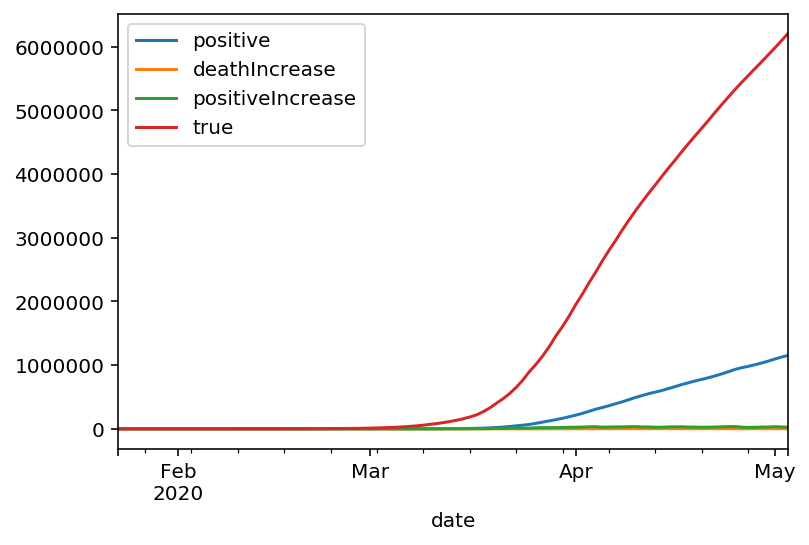

In [74]:
df.plot()